In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Bidirectional, LSTM, Reshape, GlobalAveragePooling1D, BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Activation, GRU, Input, SeparableConv2D
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import tensorflow_io as tfio
import shutil
from tqdm import tqdm

SAMPLE_RATE = 16000

2025-05-23 15:11:10.192996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748013070.386140      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748013070.446409      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_uti

In [2]:
!pip install pyunpack
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 3.2 MB/s eta 0:00:00


In [3]:
from pyunpack import Archive
if not os.path.exists('/kaggle/working/train/'):
    os.makedirs('/kaggle/working/train/')
Archive('/kaggle/input/tensorflow-speech-recognition-challenge/train.7z').extractall('/kaggle/working/train/')

In [4]:
dataset_path = '/kaggle/working/train/train/audio'
data_dir = pathlib.Path(dataset_path)

commands = [cmd for cmd in tf.io.gfile.listdir(str(data_dir)) if cmd != '_background_noise_']
commands = np.sort(np.array(commands))
print('Команды:', commands)

Команды: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [5]:
def create_stratified_split(source_dir, target_dir, test_val_ratio=0.2, random_seed=42):
    os.makedirs(os.path.join(target_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'test'), exist_ok=True)
    
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_dir) or class_name == '_background_noise_':
            continue
            
        all_files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
        if not all_files:
            continue
            
        train_files, temp_files = train_test_split(
            all_files,
            test_size=test_val_ratio,
            random_state=random_seed
        )
        val_files, test_files = train_test_split(
            temp_files,
            test_size=0.5,
            random_state=random_seed
        )
        
        for folder in ['train', 'val', 'test']:
            os.makedirs(os.path.join(target_dir, folder, class_name), exist_ok=True)
        
        def copy_files(files, target_folder):
            for f in files:
                src = os.path.join(class_dir, f)
                dst = os.path.join(target_dir, target_folder, class_name, f)
                shutil.copy2(src, dst)
        
        copy_files(train_files, 'train')
        copy_files(val_files, 'val')
        copy_files(test_files, 'test')
        
        print(f'Class {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test')

In [6]:
SOURCE_DIR = '/kaggle/working/train/train/audio'
TARGET_DIR = '/kaggle/working/split_data'
    
create_stratified_split(SOURCE_DIR, TARGET_DIR)
    
total_train = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'train')))
total_val = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'val')))
total_test = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'test')))
    
print('\nИтоговые размеры:')
print(f'Train: {total_train} файлов')
print(f'Val: {total_val} файлов')
print(f'Test: {total_test} файлов')

Class right: 1893 train, 237 val, 237 test
Class nine: 1891 train, 236 val, 237 test
Class marvin: 1396 train, 175 val, 175 test
Class off: 1885 train, 236 val, 236 test
Class happy: 1393 train, 174 val, 175 test
Class no: 1900 train, 237 val, 238 test
Class zero: 1900 train, 238 val, 238 test
Class eight: 1881 train, 235 val, 236 test
Class five: 1885 train, 236 val, 236 test
Class bed: 1370 train, 171 val, 172 test
Class go: 1897 train, 237 val, 238 test
Class seven: 1901 train, 238 val, 238 test
Class bird: 1384 train, 173 val, 174 test
Class cat: 1386 train, 173 val, 174 test
Class four: 1897 train, 237 val, 238 test
Class wow: 1396 train, 174 val, 175 test
Class tree: 1386 train, 173 val, 174 test
Class up: 1900 train, 237 val, 238 test
Class down: 1887 train, 236 val, 236 test
Class dog: 1396 train, 175 val, 175 test
Class two: 1898 train, 237 val, 238 test
Class stop: 1904 train, 238 val, 238 test
Class one: 1896 train, 237 val, 237 test
Class on: 1893 train, 237 val, 237 test
C

In [7]:
def add_random_noise(waveform, max_noise_level=0.02):
    noise_level = tf.random.uniform(shape=[], maxval=max_noise_level)
    noise = tf.random.normal(shape=tf.shape(waveform), mean=0.0, stddev=noise_level)
    return waveform + noise

In [8]:
def random_volume(waveform, min_factor=0.5, max_factor=1.5):
    factor = tf.random.uniform(shape=[], minval=min_factor, maxval=max_factor)
    return waveform * factor

In [9]:
def time_shift(waveform, shift_max=0.2):
    shift = int(tf.random.uniform([], -shift_max, shift_max) * SAMPLE_RATE)
    return tf.roll(waveform, shift, axis=0)

In [10]:
def stretch_time(waveform, min_rate=0.8, max_rate=1.25):
    rate = tf.random.uniform([], minval=min_rate, maxval=max_rate)

    def _np_stretch(wav_np, rate_np):
        import numpy as np
        orig_len = wav_np.shape[0]
        
        target_len = int(orig_len * float(rate_np))
        if target_len < 2:
            return wav_np

        x_old = np.linspace(0, orig_len - 1, orig_len)
        x_new = np.linspace(0, orig_len - 1, target_len)
        
        stretched = np.interp(x_new, x_old, wav_np).astype(np.float32)

        if stretched.shape[0] < orig_len:
            pad = np.zeros(orig_len - stretched.shape[0], dtype=np.float32)
            stretched = np.concatenate([stretched, pad])
        else:
            stretched = stretched[:orig_len]
        return stretched

    stretched = tf.numpy_function(_np_stretch, [waveform, rate], tf.float32)
    stretched.set_shape(waveform.shape)
    return stretched


In [11]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

In [12]:
def add_augmented_files(dataset_dir):
    for class_name in tqdm(os.listdir(dataset_dir), desc='Processing classes'):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir) or class_name == '_background_noise_':
            continue

        existing_files = set(os.listdir(class_dir))

        for filename in os.listdir(class_dir):
            if filename.startswith('aug_'):
                continue

            input_path = os.path.join(class_dir, filename)
            aug_filename = f'aug_{filename}'

            if aug_filename not in existing_files:
                audio_binary = tf.io.read_file(input_path)
                waveform = decode_audio(audio_binary)

                augmented = add_random_noise(
                    random_volume(
                        time_shift(
                            stretch_time(waveform)
                        )
                    )
                )

                aug_path = os.path.join(class_dir, aug_filename)
                wav_data = tf.audio.encode_wav(augmented[:, tf.newaxis], SAMPLE_RATE)
                tf.io.write_file(aug_path, wav_data)


In [13]:
dataset_path = '/kaggle/working/split_data/train'
add_augmented_files(dataset_path)

Processing classes:   0%|          | 0/30 [00:00<?, ?it/s]I0000 00:00:1748013205.534958      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748013205.535829      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Processing classes: 100%|██████████| 30/30 [04:32<00:00,  9.09s/it]


In [14]:
def load_split_dataset(base_dir):
    base = pathlib.Path(base_dir)

    train_files = [str(p) for p in base.joinpath('train').rglob('*.wav')]
    val_files   = [str(p) for p in base.joinpath('val').rglob('*.wav')]
    test_files  = [str(p) for p in base.joinpath('test').rglob('*.wav')]

    return train_files, val_files, test_files

In [15]:
train_files, val_files, test_files = load_split_dataset(TARGET_DIR)

print(f'Train files: {len(list(train_files))}')
print(f'Val files: {len(list(val_files))}')
print(f'Test files: {len(list(test_files))}')

Train files: 103528
Val files: 6471
Test files: 6486


In [16]:
def get_label(file_path):
  parts = tf.strings.split(input=file_path,sep=os.path.sep)
  return parts[-2]

In [17]:
def get_waveform_and_label(file_path):
  label = get_label(file_path) 
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# MelSpectDataSet

In [18]:
def get_mel_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)

    spectrogram = tf.signal.stft(waveform, frame_length=400, frame_step=160)
    spectrogram = tf.abs(spectrogram)

    num_mel_bins = 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=16000,
        lower_edge_hertz=80.0,
        upper_edge_hertz=7600.0
    )

    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    return mel_spectrogram

In [19]:
def get_mel_spectrogram_and_label_id(audio, label):
    mel_spectrogram = get_mel_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return mel_spectrogram, label_id

In [20]:
def preprocess_mel_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    return (
        files_ds
        .map(get_waveform_and_label,      num_parallel_calls=tf.data.AUTOTUNE)
        .map(get_mel_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
    )


In [21]:
spectrogram_mel_ds = preprocess_mel_dataset(train_files)
test_mel_ds = preprocess_mel_dataset(test_files)

In [22]:
batch_size = 128
train_mel_ds = (
    preprocess_mel_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
val_mel_ds = (
    preprocess_mel_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
for mel_spectrogram, _ in spectrogram_mel_ds.take(1):
  input_mel_shape = mel_spectrogram.shape
print('Размер входа', input_mel_shape)

num_labels = len(commands)

Размер входа (98, 80, 1)


# Dense

In [24]:
model_mel_dense = models.Sequential([
    layers.Input(shape=(input_mel_shape[0] * input_mel_shape[1],)),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
])

model_mel_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │       8,029,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,729,246 (33.30 MB)

 Trainable params: 8,725,662 (33.29 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [25]:
model_mel_dense.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
train_ds_dense = train_mel_ds.map(lambda x, y: (tf.reshape(x, [-1, input_mel_shape[0] * input_mel_shape[1]]), y))
val_ds_dense = val_mel_ds.map(lambda x, y: (tf.reshape(x, [-1, input_mel_shape[0] * input_mel_shape[1]]), y))
test_ds_dense = test_mel_ds.map(lambda x, y: (tf.reshape(x, [-1, input_mel_shape[0] * input_mel_shape[1]]), y))

In [27]:
EPOCHS = 200
history_dense = model_mel_dense.fit(
    train_ds_dense,
    validation_data=val_ds_dense,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
)

Epoch 1/200


I0000 00:00:1748013534.466763     110 service.cc:148] XLA service 0x7839d4008b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748013534.468463     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748013534.468491     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748013534.892228     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/809 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0300 - loss: 3.9970  

I0000 00:00:1748013538.071310     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


809/809 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - accuracy: 0.1025 - loss: 3.2628 - val_accuracy: 0.3930 - val_loss: 2.0092
Epoch 2/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3031 - loss: 2.3161 - val_accuracy: 0.5454 - val_loss: 1.5087
Epoch 3/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3942 - loss: 2.0058 - val_accuracy: 0.5951 - val_loss: 1.3120
Epoch 4/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4481 - loss: 1.8219 - val_accuracy: 0.6619 - val_loss: 1.1287
Epoch 5/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4879 - loss: 1.6851 - val_accuracy: 0.6861 - val_loss: 1.0403
Epoch 6/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5097 - loss: 1.6088 - val_accuracy: 0.6772 - val_loss: 1.0216
Epoch 7/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5374 - loss: 1.5189 - val_accuracy: 0.7212 - val_loss: 0.9198
Epoch 8/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5490 - loss: 1.4771 - val_accuracy: 0.72

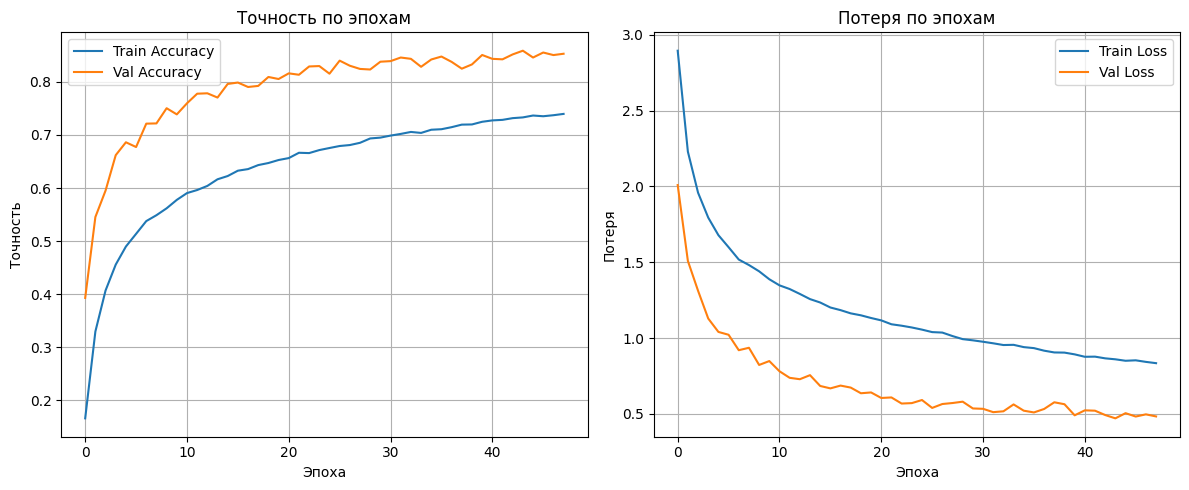

In [28]:
metrics = history_dense.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dense.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_dense.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_dense.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_dense.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mel_dense.png", dpi=300)
plt.show()

In [29]:
test_mel_audio = []
test_mel_labels = []

for audio, label in test_ds_dense:
  test_mel_audio.append(audio.numpy())
  test_mel_labels.append(label.numpy())

test_mel_audio = np.array(test_mel_audio)
test_mel_labels = np.array(test_mel_labels)

test_mel_audio = np.squeeze(test_mel_audio, axis=1)

In [30]:
y_pred = np.argmax(model_mel_dense.predict(test_mel_audio), axis=1)
y_true = test_mel_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Точность на тестовом наборе: 86%


In [31]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.8393    0.8198    0.8294       172
        bird     0.8933    0.9138    0.9034       174
         cat     0.8960    0.8908    0.8934       174
         dog     0.7500    0.6686    0.7069       175
        down     0.8274    0.6907    0.7529       236
       eight     0.8835    0.9322    0.9072       236
        five     0.8713    0.7458    0.8037       236
        four     0.9550    0.8908    0.9217       238
          go     0.7569    0.6933    0.7237       238
       happy     0.9322    0.9429    0.9375       175
       house     0.9661    0.9771    0.9716       175
        left     0.9116    0.8305    0.8692       236
      marvin     0.9314    0.9314    0.9314       175
        nine     0.9279    0.8143    0.8674       237
          no     0.7593    0.7689    0.7641       238
         off     0.8436    0.8686    0.8559       236
          on     0.8080    0.8523    0.8296       237
         one     0.8281    

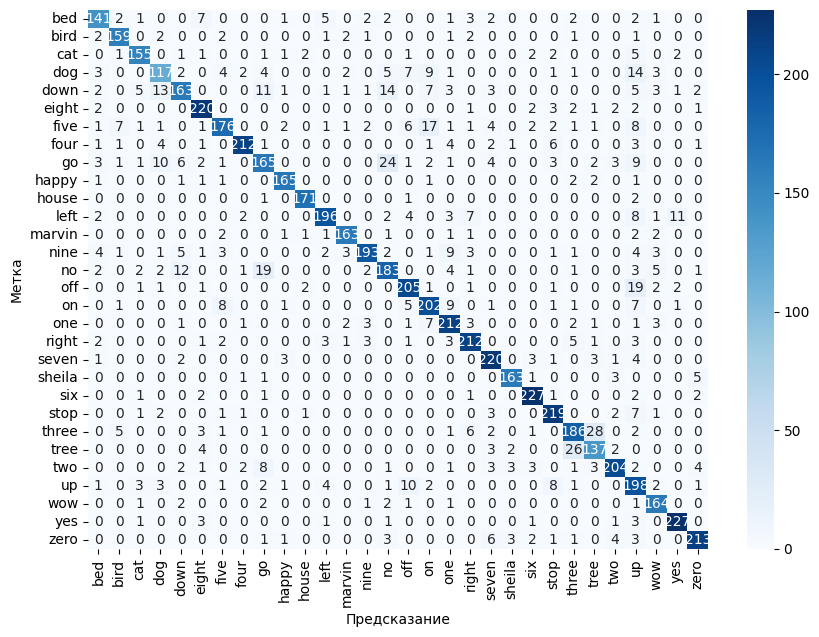

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mel_dense.png", dpi=300)
plt.show()

In [33]:
model_mel_dense.save('mel_dense.keras')

# CNNLight

In [34]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_mel_ds.map(map_func=lambda spec, label: spec))

In [35]:
model_mel_cnn_light = models.Sequential([
    layers.Input(shape=input_mel_shape),
    layers.Resizing(32, 32),
    norm_layer,
    
    # Блок 1: небольшое ядро (3x3) для извлечения локальных особенностей
    layers.Conv2D(32, kernel_size=(3,3), padding='same'),
    layers.Activation('relu'),
    
    # Блок 2: среднее ядро (5x5) для расширения рецептивного поля
    layers.Conv2D(64, kernel_size=(5,5), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Блок 3: увеличенное ядро (7x7) для извлечения признаков с более глобальным охватом
    layers.Conv2D(128, kernel_size=(7,7), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Блок 4: ещё большее ядро (9x9) для максимально широкого охвата пространственных зависимостей
    layers.Conv2D(256, kernel_size=(9,9), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(num_labels),
])

model_mel_cnn_light.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,635,873 (13.87 MB)

 Trainable params: 3,635,870 (13.87 MB)

 Non-trainable params: 3 (16.00 B)

In [36]:
model_mel_cnn_light.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 50
history = model_mel_cnn_light.fit(
    train_mel_ds,
    validation_data=val_mel_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
)
metrics = history.history

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.3132 - loss: 2.3998 - val_accuracy: 0.9144 - val_loss: 0.2992
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7991 - loss: 0.7014 - val_accuracy: 0.9340 - val_loss: 0.2209
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8520 - loss: 0.5202 - val_accuracy: 0.9470 - val_loss: 0.1847
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8746 - loss: 0.4430 - val_accuracy: 0.9541 - val_loss: 0.1639
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8884 - loss: 0.3884 - val_accuracy: 0.9530 - val_loss: 0.1606
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8953 - loss: 0.3623 - val_accuracy: 0.9555 - val_loss: 0.1569
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.9000 - loss: 0.3456 - val_accuracy: 0.9575 - val_loss: 0.1568
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.9071 - loss: 0.3204 - 

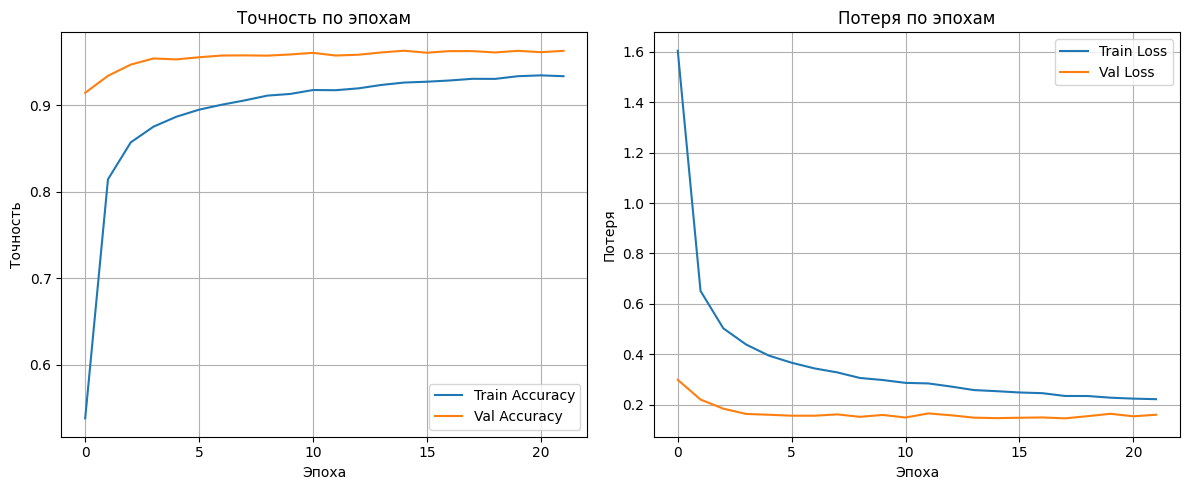

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mel_cnn_light.png", dpi=300)
plt.show()

In [39]:
test_mel_audio = []
test_mel_labels = []

for audio, label in test_mel_ds:
  test_mel_audio.append(audio.numpy())
  test_mel_labels.append(label.numpy())

test_mel_audio = np.array(test_mel_audio)
test_mel_labels = np.array(test_mel_labels)

In [40]:
y_pred = np.argmax(model_mel_cnn_light.predict(test_mel_audio), axis=1)
y_true = test_mel_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Точность на тестовом наборе: 97%


In [41]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9392    0.9884    0.9632       172
        bird     0.9940    0.9598    0.9766       174
         cat     0.9716    0.9828    0.9771       174
         dog     0.9827    0.9714    0.9770       175
        down     0.9868    0.9534    0.9698       236
       eight     0.9702    0.9661    0.9682       236
        five     0.9825    0.9492    0.9655       236
        four     0.9791    0.9832    0.9811       238
          go     0.9194    0.9580    0.9383       238
       happy     1.0000    0.9886    0.9943       175
       house     1.0000    0.9943    0.9971       175
        left     0.9824    0.9449    0.9633       236
      marvin     1.0000    0.9771    0.9884       175
        nine     0.9702    0.9620    0.9661       237
          no     0.9504    0.9664    0.9583       238
         off     0.9730    0.9153    0.9432       236
          on     0.9617    0.9536    0.9576       237
         one     0.9665    

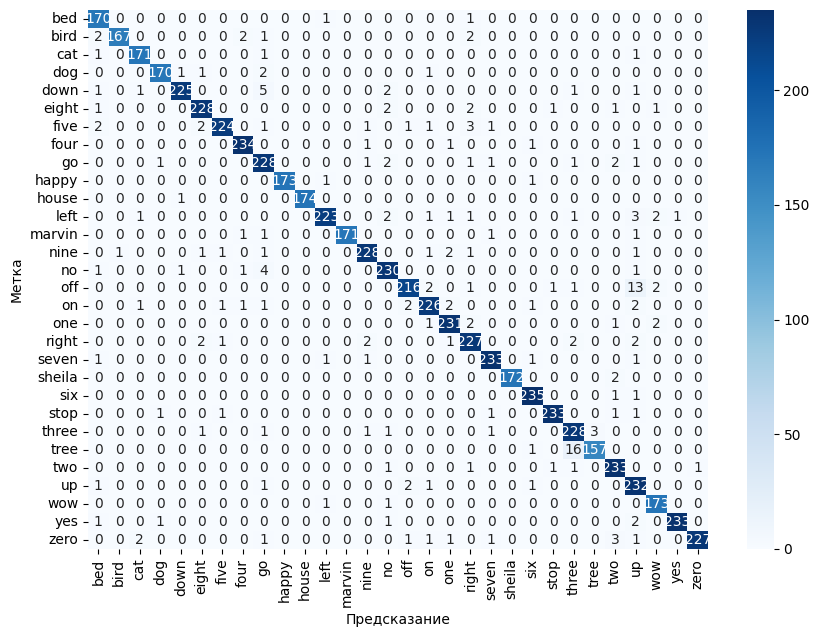

In [42]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mel_cnn_light.png", dpi=300)
plt.show()

In [43]:
model_mel_cnn_light.save('mel_cnn_light.keras')

# CNNHard

In [44]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_mel_ds.map(map_func=lambda spec, label: spec))

In [47]:
model_mel_cnn = models.Sequential([
    layers.Input(shape=input_mel_shape),
    layers.Resizing(64, 64),
    norm_layer,

    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=7, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(512, kernel_size=9, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_labels)
])

model_mel_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 256)         │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,557,089 (55.53 MB)

 Trainable params: 14,554,590 (55.52 MB)

 Non-trainable params: 2,499 (9.77 KB)

In [48]:
model_mel_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [49]:
EPOCHS = 50
history = model_mel_cnn.fit(
    train_mel_ds,
    validation_data=val_mel_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
)
metrics = history.history

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 164s 171ms/step - accuracy: 0.2943 - loss: 2.7077 - val_accuracy: 0.8946 - val_loss: 0.3583
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 145ms/step - accuracy: 0.8359 - loss: 0.5610 - val_accuracy: 0.9388 - val_loss: 0.2112
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.8836 - loss: 0.3964 - val_accuracy: 0.9345 - val_loss: 0.2216
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9051 - loss: 0.3235 - val_accuracy: 0.9560 - val_loss: 0.1469
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9157 - loss: 0.2880 - val_accuracy: 0.9607 - val_loss: 0.1412
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9258 - loss: 0.2499 - val_accuracy: 0.9597 - val_loss: 0.1362
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9330 - loss: 0.2290 - val_accuracy: 0.9641 - val_loss: 0.1306
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9380 -

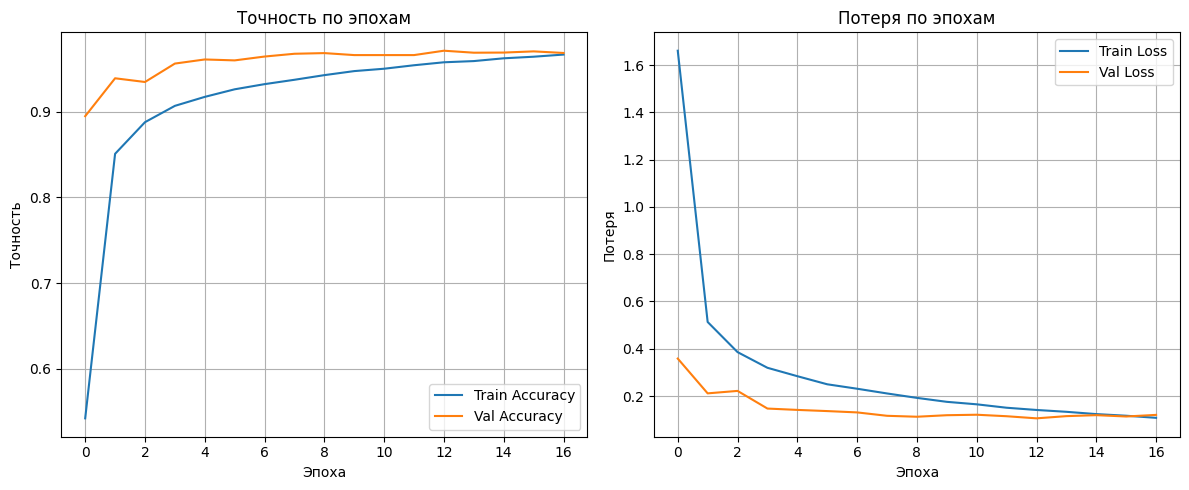

In [50]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mel_cnn.png", dpi=300)
plt.show()

In [51]:
test_mel_audio = []
test_mel_labels = []

for audio, label in test_mel_ds:
  test_mel_audio.append(audio.numpy())
  test_mel_labels.append(label.numpy())

test_mel_audio = np.array(test_mel_audio)
test_mel_labels = np.array(test_mel_labels)

In [52]:
y_pred = np.argmax(model_mel_cnn.predict(test_mel_audio), axis=1)
y_true = test_mel_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Точность на тестовом наборе: 97%


In [53]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9659    0.9884    0.9770       172
        bird     0.9884    0.9770    0.9827       174
         cat     0.9884    0.9770    0.9827       174
         dog     1.0000    0.9543    0.9766       175
        down     0.9585    0.9788    0.9686       236
       eight     0.9913    0.9703    0.9807       236
        five     0.9828    0.9703    0.9765       236
        four     0.9549    0.9790    0.9668       238
          go     0.9826    0.9496    0.9658       238
       happy     0.9611    0.9886    0.9746       175
       house     0.9884    0.9771    0.9828       175
        left     0.9870    0.9619    0.9742       236
      marvin     0.9885    0.9829    0.9857       175
        nine     0.9545    0.9747    0.9645       237
          no     0.9747    0.9706    0.9726       238
         off     0.9730    0.9153    0.9432       236
          on     0.9498    0.9578    0.9538       237
         one     0.9419    

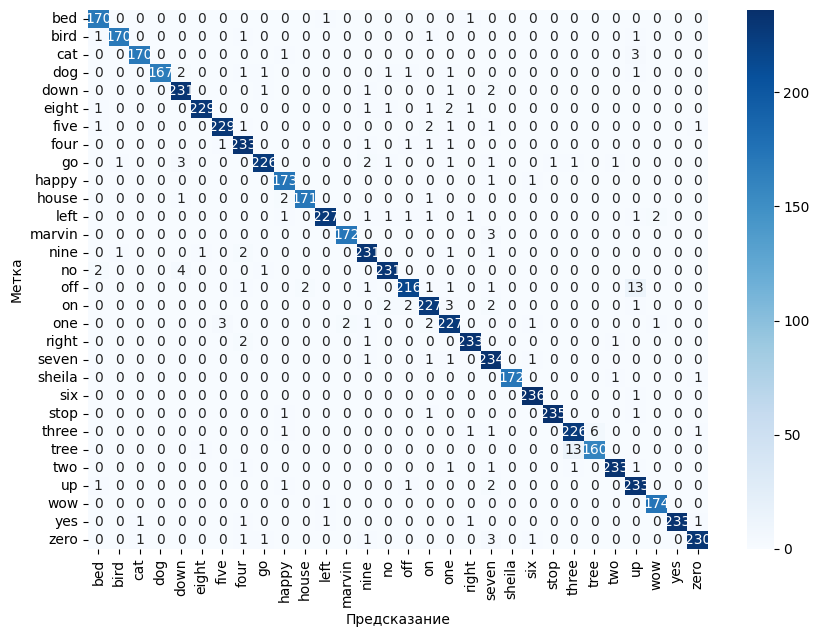

In [54]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mel_cnn.png", dpi=300)
plt.show()

In [55]:
model_mel_cnn.save('mel_cnn.keras')

# TCN

In [56]:
def get_mel_spectrogram_and_label_id(audio, label):
    mel_spectrogram = get_mel_spectrogram(audio)
    mel_spectrogram = tf.squeeze(mel_spectrogram, axis=-1)
    label_id = tf.argmax(label == commands)
    return mel_spectrogram, label_id

In [57]:
spectrogram_mel_ds = preprocess_mel_dataset(train_files)
test_mel_ds = preprocess_mel_dataset(test_files)

In [58]:
batch_size = 128

train_mel_ds = (
    preprocess_mel_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_mel_ds = (
    preprocess_mel_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [59]:
for mel_spectrogram, _ in spectrogram_mel_ds.take(1):
  input_shape = mel_spectrogram.shape
print('Размер входа', input_shape)

num_labels = len(commands)

Размер входа (98, 80)


In [60]:
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_mel_ds.map(lambda x, y: x))

In [61]:
model_mel_tcn = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    
    layers.Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(128, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(256, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(256, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Conv1D(256, kernel_size=3, dilation_rate=8, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.GlobalAveragePooling1D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

model_mel_tcn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (None, 98, 80)              │             161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 64)              │          15,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 98, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 98, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 98, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 49, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 49, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 49, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 49, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 24, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 24, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 24, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 672,319 (2.56 MB)

 Trainable params: 669,854 (2.56 MB)

 Non-trainable params: 2,465 (9.63 KB)

In [62]:
model_mel_tcn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [63]:
EPOCHS = 50
history_tcn = model_mel_tcn.fit(
    train_mel_ds,
    validation_data=val_mel_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


809/809 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - accuracy: 0.3876 - loss: 2.1140 - val_accuracy: 0.8739 - val_loss: 0.4356
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7892 - loss: 0.7140 - val_accuracy: 0.9098 - val_loss: 0.3211
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8397 - loss: 0.5540 - val_accuracy: 0.9269 - val_loss: 0.2461
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8617 - loss: 0.4743 - val_accuracy: 0.9301 - val_loss: 0.2388
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8749 - loss: 0.4282 - val_accuracy: 0.9369 - val_loss: 0.2192
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8837 - loss: 0.3989 - val_accuracy: 0.9399 - val_loss: 0.1979
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8900 - loss: 0.3705 - val_accuracy: 0.9468 - val_loss: 0.1917
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8957 - loss: 0.3509 - val_accuracy: 0.94

In [64]:
model_mel_tcn.save("mel_tcn.keras")

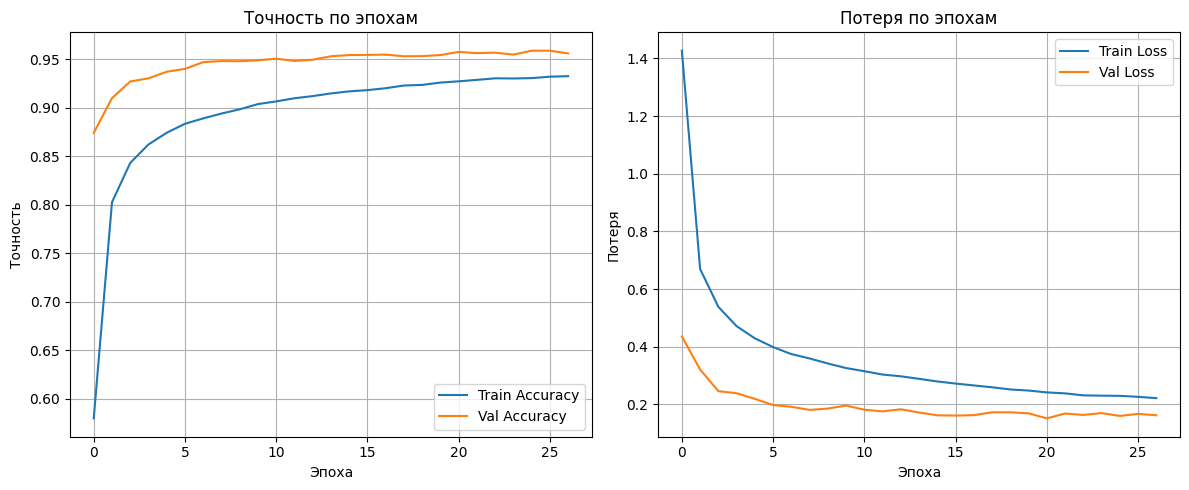

In [65]:
metrics = history_tcn.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_tcn.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_tcn.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_tcn.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_tcn.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mel_tcn.png", dpi=300)
plt.show()

In [66]:
test_audio = []
test_labels = []

for audio, label in test_mel_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
    

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [67]:
y_pred = np.argmax(model_mel_tcn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Точность на тестовом наборе: 96%


In [68]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9494    0.9826    0.9657       172
        bird     0.9609    0.9885    0.9745       174
         cat     0.9716    0.9828    0.9771       174
         dog     0.9767    0.9600    0.9683       175
        down     0.9784    0.9576    0.9679       236
       eight     0.9739    0.9492    0.9614       236
        five     0.9696    0.9449    0.9571       236
        four     0.9402    0.9916    0.9652       238
          go     0.9526    0.9286    0.9404       238
       happy     1.0000    0.9829    0.9914       175
       house     0.9887    1.0000    0.9943       175
        left     0.9911    0.9407    0.9652       236
      marvin     0.9942    0.9714    0.9827       175
        nine     0.9869    0.9536    0.9700       237
          no     0.9665    0.9706    0.9686       238
         off     0.9322    0.9322    0.9322       236
          on     0.9688    0.9156    0.9414       237
         one     0.9315    

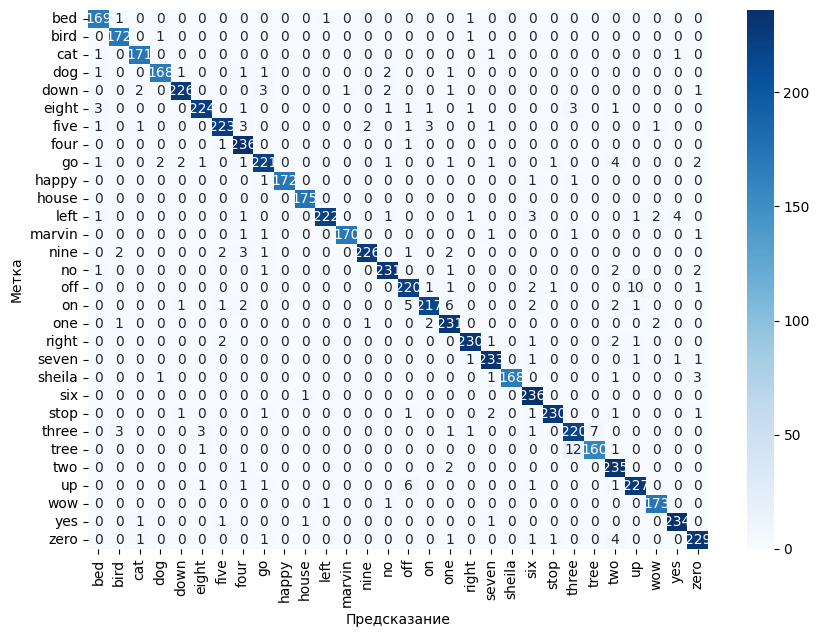

In [69]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mel_tcn.png", dpi=300)
plt.show()

# CRNN-LSTM

In [73]:
def get_mel_spectrogram_and_label_id(audio, label):
    mel_spectrogram = get_mel_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return mel_spectrogram, label_id

In [74]:
spectrogram_mel_ds = preprocess_mel_dataset(train_files)
test_mel_ds = preprocess_mel_dataset(test_files)

In [75]:
batch_size = 64

train_mel_ds = (
    preprocess_mel_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_mel_ds = (
    preprocess_mel_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [76]:
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_mel_ds.map(lambda x, y: x))

In [77]:
for mel_spectrogram, _ in spectrogram_mel_ds.take(1):
  input_shape = mel_spectrogram.shape
print('Размер входа', input_shape)

num_labels = len(commands)

Размер входа (98, 80, 1)


In [79]:
model_mel_crnn = models.Sequential([
    layers.Input(shape=input_mel_shape),
    layers.Resizing(64, 64),
    norm_layer,

    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(512, kernel_size=7, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    # Предполагается, что после последнего слоя размерность равна (4, 4, 512)
    # Преобразуем в последовательность длиной 16 (4*4) с 512 признаками на шаг
    layers.Reshape((16, 512)),

    # Рекуррентные слои для моделирования последовательной зависимости
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_labels)
])

model_mel_crnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)                │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_3 (Normalization)      │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,595,361 (32.79 MB)

 Trainable params: 8,592,862 (32.78 MB)

 Non-trainable params: 2,499 (9.77 KB)

In [80]:
model_mel_crnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [81]:
# Обучение
EPOCHS = 150
history_crnn = model_mel_crnn.fit(
    train_mel_ds,
    validation_data=val_mel_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
)

Epoch 1/150


E0000 00:00:1748020644.057639      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_28_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 226s 103ms/step - accuracy: 0.3278 - loss: 2.4361 - val_accuracy: 0.8852 - val_loss: 0.3955
Epoch 2/150
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 163s 101ms/step - accuracy: 0.8315 - loss: 0.5732 - val_accuracy: 0.9257 - val_loss: 0.2576
Epoch 3/150
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 163s 101ms/step - accuracy: 0.8769 - loss: 0.4207 - val_accuracy: 0.9408 - val_loss: 0.2042
Epoch 4/150
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 163s 101ms/step - accuracy: 0.8976 - loss: 0.3511 - val_accuracy: 0.9524 - val_loss: 0.1633
Epoch 5/150
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 163s 101ms/step - accuracy: 0.9095 - loss: 0.3076 - val_accuracy: 0.9578 - val_loss: 0.1573
Epoch 6/150
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 164s 101ms/step - accuracy: 0.9180 - loss: 0.2775 - val_accuracy: 0.9618 - val_loss: 0.1303
Epoch 7/150
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 162s 100ms/step - accuracy: 0.9278 - loss: 0.2493 - val_accuracy: 0.9621 - val_loss: 0.1279
Epoch 8/150
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 162s 100ms/step - accura

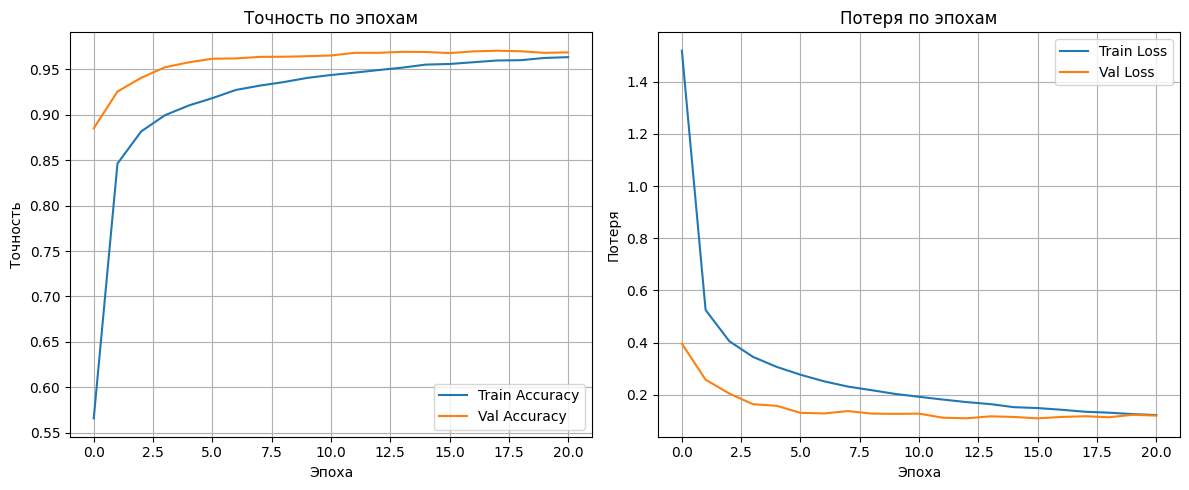

In [82]:
metrics = history_crnn.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_crnn.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_crnn.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_crnn.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_crnn.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mel_crnn.png", dpi=300)
plt.show()

In [83]:
test_audio = []
test_labels = []

for audio, label in test_mel_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [84]:
y_pred = np.argmax(model_mel_crnn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Точность на тестовом наборе: 97%


In [85]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9605    0.9884    0.9742       172
        bird     0.9882    0.9655    0.9767       174
         cat     0.9829    0.9885    0.9857       174
         dog     0.9940    0.9543    0.9738       175
        down     0.9788    0.9788    0.9788       236
       eight     0.9504    0.9746    0.9623       236
        five     0.9167    0.9788    0.9467       236
        four     1.0000    0.9790    0.9894       238
          go     0.9667    0.9748    0.9707       238
       happy     1.0000    0.9829    0.9914       175
       house     0.9943    1.0000    0.9972       175
        left     0.9956    0.9661    0.9806       236
      marvin     0.9942    0.9714    0.9827       175
        nine     0.9787    0.9705    0.9746       237
          no     0.9832    0.9832    0.9832       238
         off     0.9730    0.9153    0.9432       236
          on     0.9084    0.9620    0.9344       237
         one     0.9870    

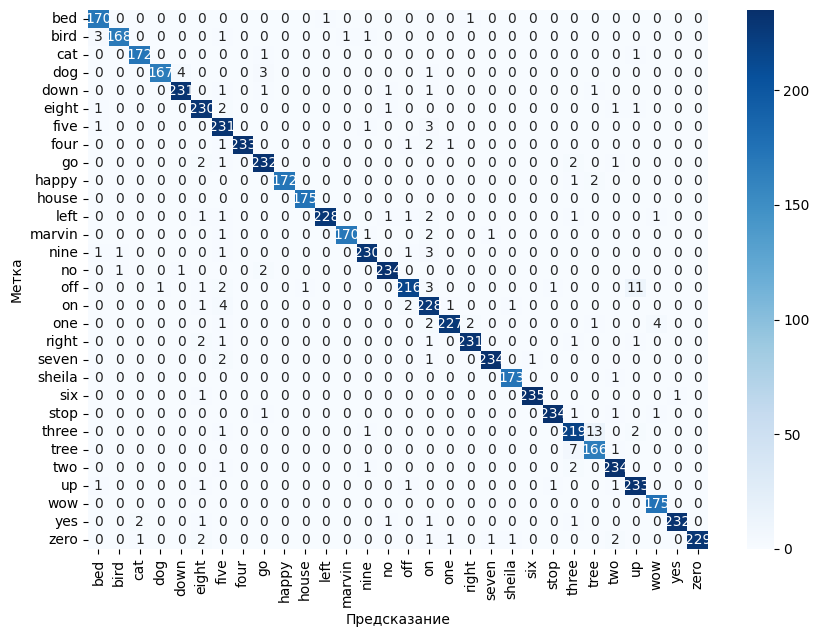

In [86]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mel_crnn.png", dpi=300)
plt.show()

In [87]:
model_mel_crnn.save("mel_crnn.keras")